### Import libraries

In [12]:
import numpy as np
import pandas as pd
import os

In [27]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras.models import Model
from keras.utils import to_categorical

### Load the pre-trained vgg16 model

In [45]:
base_model = VGG16()

### Remove the last layer ( the predicition layer ) so we can extract features

In [46]:
base_model.layers.pop()
base_model = Model(base_model.inputs,base_model.layers[-1].output)

In [47]:
# Define my architecture.

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Iterate over all training images and load them and extract their features using vgg16

In [34]:
X,Y = [],[]
for folder in os.listdir('training'):
    label = int(folder[1])
    label_co = to_categorical(label, num_classes=10)[0]
    for im in os.listdir(os.path.join('training',folder)):
        path = os.path.join(os.path.join('training',folder),im)
        img = image.load_img(path, target_size=(224,224))
        img = image.img_to_array(img)
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        img = preprocess_input(img)
        X.append(base_model.predict(img)[0])
        Y.append(label_co)
        if len(X)%200 == 0:
            print(len(X))

200
400
600
800
1000


In [35]:
x_train, y_train = np.array(X), np.array(Y)

In [36]:
# print number of training files

print(x_train.shape,y_train.shape)

(1098, 4096) (1098, 10)


### Same for validation data

In [48]:
X,Y = [],[]
for folder in os.listdir('validation'):
    label = int(folder[1])
    label_co = to_categorical(label, num_classes=10)[0]
    for im in os.listdir(os.path.join('validation',folder)):
        path = os.path.join(os.path.join('validation',folder),im)
        img = image.load_img(path, target_size=(224,224))
        img = image.img_to_array(img)
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        img = preprocess_input(img)
        X.append(base_model.predict(img)[0])
        Y.append(label_co)
        if len(X)%200 == 0:
            print(len(X))

200


In [49]:
x_val, y_val = np.array(X), np.array(Y)

In [50]:
# print number of validation images

print(x_val.shape,y_val.shape)

(272, 4096) (272, 10)


### Build a simple network to classify monkeys given their extracted features

In [51]:
from keras.models import Model
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# input features
in1 = layers.Input(shape=(4096,))

# a fully connected layer with dropout
X = layers.Dense(1024,activation='relu')(in1)
X = layers.Dropout(0.7)(X)

# final layer
X = layers.Dense(10,activation='softmax')(X)

model = Model(inputs=in1,outputs=X)

In [53]:
# compilation model.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# specify the number of epochs that you would like to use to train the model.

hist = model.fit(x_train,y_train,validation_data=[x_val,y_val],epochs=16,verbose=2)

Train on 1098 samples, validate on 272 samples
Epoch 1/16
 - 1s - loss: 1.1243 - acc: 0.8024 - val_loss: 0.1575 - val_acc: 0.9632
Epoch 2/16
 - 0s - loss: 0.3422 - acc: 0.9444 - val_loss: 0.2194 - val_acc: 0.9559
Epoch 3/16
 - 0s - loss: 0.2953 - acc: 0.9517 - val_loss: 0.2684 - val_acc: 0.9412
Epoch 4/16
 - 0s - loss: 0.3539 - acc: 0.9554 - val_loss: 0.0613 - val_acc: 0.9816
Epoch 5/16
 - 0s - loss: 0.2309 - acc: 0.9663 - val_loss: 0.1239 - val_acc: 0.9743
Epoch 6/16
 - 0s - loss: 0.1341 - acc: 0.9718 - val_loss: 0.0801 - val_acc: 0.9853
Epoch 7/16
 - 0s - loss: 0.1616 - acc: 0.9745 - val_loss: 0.1890 - val_acc: 0.9706
Epoch 8/16
 - 0s - loss: 0.3106 - acc: 0.9590 - val_loss: 0.1970 - val_acc: 0.9632
Epoch 9/16
 - 0s - loss: 0.2349 - acc: 0.9681 - val_loss: 0.0736 - val_acc: 0.9816
Epoch 10/16
 - 0s - loss: 0.1946 - acc: 0.9745 - val_loss: 0.1449 - val_acc: 0.9706
Epoch 11/16
 - 0s - loss: 0.1187 - acc: 0.9845 - val_loss: 0.0346 - val_acc: 0.9853
Epoch 12/16
 - 0s - loss: 0.1568 - acc

### plot training history

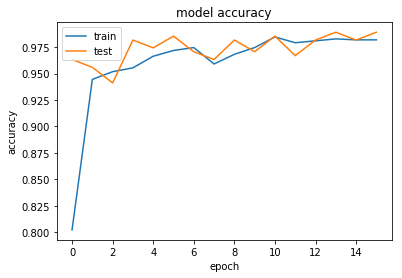

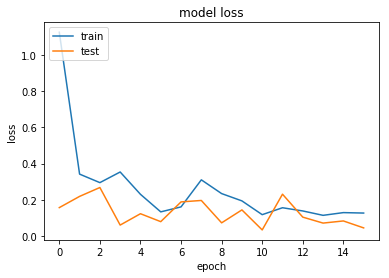

In [55]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Create a function, that given a monkey image path, can classify monkey

In [61]:
def predict_class(path):
    # show the image
    plt.imshow(plt.imread(path))
    # load image with size (224,224,3)
    img = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(img)
    # reshape to (#sample,224,224,3)
    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    img = preprocess_input(img)
    p = model.predict(base_model.predict(img))
    print(np.argmax(p))

### Test a few iamges

1


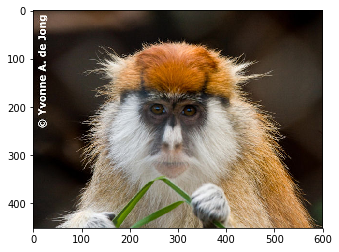

In [62]:
predict_class('training/n1/n1018.jpg')

2


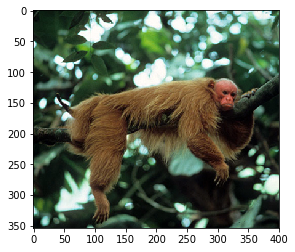

In [63]:
predict_class('training/n2/n2024.jpg')

8


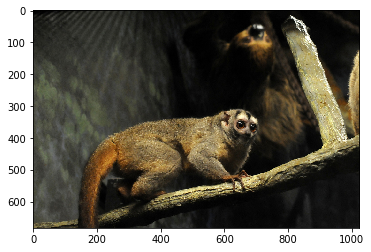

In [64]:
predict_class('validation/n8/n807.jpg')